# Stock_Price_Prediction_Using_LSTM

### STEP1: IMPORTING LIBRARIES AND DATA TO BE USED

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import itertools
import random
import os
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [ ]:
df = pd.read_csv('/content/TSLA .csv')# data_importing
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
1,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500
2,2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000
3,2010-07-09,1.172000,1.193333,1.103333,1.160000,1.160000,60759000
4,2010-07-12,1.196667,1.204667,1.133333,1.136667,1.136667,33037500
5,2010-07-13,1.159333,1.242667,1.126667,1.209333,1.209333,40201500
6,2010-07-14,1.196000,1.343333,1.184000,1.322667,1.322667,62928000
7,2010-07-15,1.329333,1.433333,1.266667,1.326000,1.326000,56097000
8,2010-07-16,1.380000,1.420000,1.336667,1.376000,1.376000,39319500
9,2010-07-19,1.424667,1.483333,1.394667,1.460667,1.460667,37297500


In [ ]:
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
3332,2023-09-29,250.000000,254.770004,246.350006,250.220001,250.220001,128346200
3333,2023-10-02,244.809998,254.279999,242.619995,251.600006,251.600006,123810400
3334,2023-10-03,248.610001,250.020004,244.449997,246.529999,246.529999,101985300
3335,2023-10-04,248.139999,261.859985,247.600006,261.160004,261.160004,129721600
3336,2023-10-05,260.000000,263.600006,256.250000,260.049988,260.049988,119159200


### STEP 2 : GATHERING INSIGHTS

In [ ]:
print("Shape of data:",df.shape)

Shape of data: (3337, 7)


In [ ]:
# statistical description of data
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3.337000e+03
mean,67.636869,69.144214,66.016805,67.621653,67.621653,9.630168e+07
std,100.004681,102.265686,97.518960,99.930246,99.930246,8.058505e+07
min,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,10.160000,10.476667,9.910667,10.094000,10.094000,4.533900e+07
50%,16.770666,17.000000,16.534666,16.770000,16.770000,8.002200e+07
75%,64.600670,66.333336,62.476665,64.056664,64.056664,1.230315e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [ ]:
# summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3337 entries, 0 to 3336
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3337 non-null   object 
 1   Open       3337 non-null   float64
 2   High       3337 non-null   float64
 3   Low        3337 non-null   float64
 4   Close      3337 non-null   float64
 5   Adj Close  3337 non-null   float64
 6   Volume     3337 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 182.6+ KB


In [ ]:
# checking null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### There are no null values in the dataset

In [ ]:
# Selecting necessary features and Converting object dtype  date to datetime

In [ ]:
df = df[['Date','Close']]

# Extracting required columns
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x.split()[0])) # converting object dtype of date column to datetime dtype
df.set_index('Date',drop=True,inplace=True) # Setting date column as index
df.head(10)

,Close
Date,
2010-07-06,1.074000
2010-07-07,1.053333
2010-07-08,1.164000
2010-07-09,1.160000
2010-07-12,1.136667
2010-07-13,1.209333
2010-07-14,1.322667
2010-07-15,1.326000
2010-07-16,1.376000


In [ ]:
df['Close'] = df['Close'].astype(float)

plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label = 'Tesla Stock Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.legend()
plt.show()

### DATA PRE-PROCESSING

In [ ]:
# normalizing all the values of all columns using MinMaxScaler
MMS = MinMaxScaler()
df[df.columns] = MMS.fit_transform(df)
df.head(10)

,Close
Date,
2010-07-06,0.000051
2010-07-07,0.000000
2010-07-08,0.000271
2010-07-09,0.000261
2010-07-12,0.000204
2010-07-13,0.000381
2010-07-14,0.000659
2010-07-15,0.000667
2010-07-16,0.000789


In [ ]:
# splitting the data into training and test set
training_size = round(len(df) * 0.75) # Selecting 75 % for training and 25 % for testing
training_size

2503

In [ ]:
train_data = df[:training_size]
test_data = df[training_size:]
train_data.shape, test_data.shape

((2503, 1), (834, 1))

In [ ]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
    sequences = []
    labels = []

    start_idx = 0

    for stop_idx in range(6,len(dataset)): # Selecting 6 rows at a time
        sequences.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx +=1
    return (np.array(sequences), np.array(labels))

In [ ]:
X_train, y_train, = create_sequence(train_data)
X_test, y_test = create_sequence(test_data)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2497, 6, 1), (2497, 1), (828, 6, 1), (828, 1))

### CREATING LSTM MODEL

In [ ]:
# imported Sequential from keras.models
model = Sequential()
# importing Dense, Dropout, LSTM, Bidirectional from keras.layers
model.add(LSTM(units=100, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(units=100))
model.add(Dropout(0.1))


model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_absolute_error'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 6, 100)            40800     
                                                                 
 dropout_22 (Dropout)        (None, 6, 100)            0         
                                                                 
 lstm_27 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fitting the model by iterating the dataset over 100 times(100 epochs)
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test),  verbose = 1)

Epoch 1/100
79/79 [==============================] - 7s 37ms/step - loss: 1.9472e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0019 - val_mean_absolute_error: 0.0336
Epoch 2/100
79/79 [==============================] - 2s 22ms/step - loss: 1.4626e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0019 - val_mean_absolute_error: 0.0335
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 1.4546e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304
Epoch 4/100
79/79 [==============================] - 1s 15ms/step - loss: 1.4595e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0015 - val_mean_absolute_error: 0.0293
Epoch 5/100
79/79 [==============================] - 1s 15ms/step - loss: 1.6975e-05 - mean_absolute_error: 0.0027 - val_loss: 0.0014 - val_mean_absolute_error: 0.0281
Epoch 6/100
79/79 [==============================] - 1s 15ms/step - loss: 1.5689e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0014 - val_mean_absolute_error:

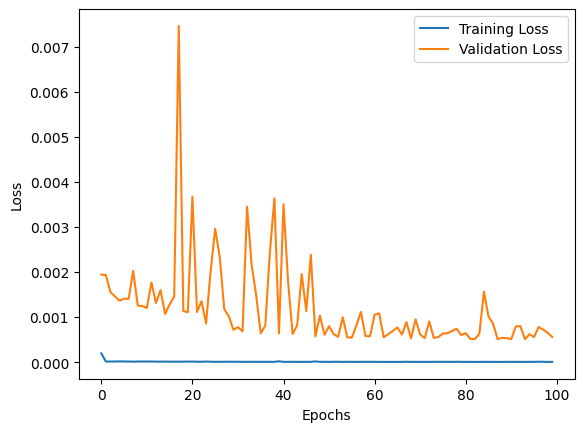

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
## Evaluating train data

In [ ]:
predict = model.predict(X_train)
predict = MMS.inverse_transform(predict)
t2 = MMS.inverse_transform(y_train)

diff = predict - t2

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

79/79 [==============================] - 2s 7ms/step
MSE: 0.5838524301452417
MAE: 0.3707623345709248
RMSE: 0.7641023688912643


In [ ]:
## Evaluating test data

In [ ]:
predict = model.predict(X_test)
predict = MMS.inverse_transform(predict)
t2 = MMS.inverse_transform(y_test)

diff = predict - t2

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

26/26 [==============================] - 0s 12ms/step
MSE: 93.28616854670305
MAE: 7.177657175202743
RMSE: 9.65847651271685


In [ ]:
## Using hypertuning

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
28/28 [==============================] - 6s 57ms/step - loss: 1.7492e-04 - mean_absolute_error: 0.0103 - val_loss: 8.4788e-05 - val_mean_absolute_error: 0.0073
Epoch 2/40
28/28 [==============================] - 1s 28ms/step - loss: 8.6101e-06 - mean_absolute_error: 0.0023 - val_loss: 3.7472e-05 - val_mean_absolute_error: 0.0037
Epoch 3/40
28/28 [==============================] - 1s 28ms/step - loss: 3.6065e-06 - mean_absolute_error: 0.0014 - val_loss: 2.9526e-05 - val_mean_absolute_error: 0.0031
Epoch 4/40
28/28 [==============================] - 1s 27ms/step - loss: 3.6672e-06 - mean_absolute_error: 0.0014 - val_loss: 2.9281e-05 - val_mean_absolute_error: 0.0031
Epoch 5/40
28/28 [==============================] - 1s 28ms/step - loss: 3.6181e-06 - mean_absolute_error: 0.0014 - val_loss: 3.0448e-05 - val_mean_absolute_error: 0.0031
Epoch 6/40
28/28 [==============================] - 1s 25ms/step - loss: 3.1968e-06 - mean_absolute_error: 0.0013 - val_loss: 2.9814e-05 - val_me

In [ ]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

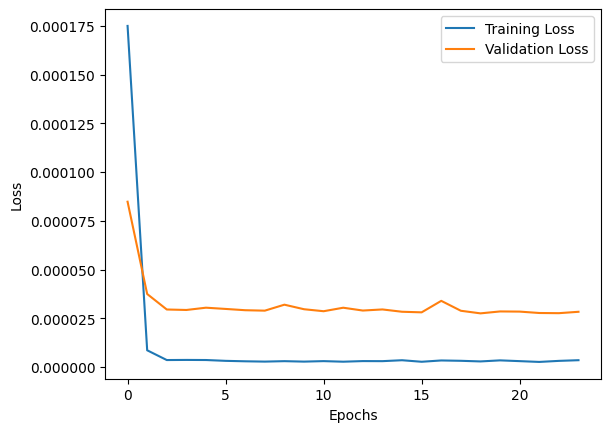

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
results = model.evaluate(X_train, y_train)
print("test loss, test acc:", np.round(results, 4))

79/79 [==============================] - 1s 9ms/step - loss: 1.1234e-05 - mean_absolute_error: 0.0022
test loss, test acc: [0.     0.0022]


In [ ]:



def LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test):

    first_additional_layer, second_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))



        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        model.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # model = load_model('best_model.h5')

        train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_accuracy = model.evaluate(X_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [ ]:
config = [[False], [False], [16, 32], [8, 16, 32], [0.2]]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, 16, 8, 0.2), (False, False, 16, 16, 0.2), (False, False, 16, 32, 0.2), (False, False, 32, 8, 0.2), (False, False, 32, 16, 0.2), (False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00005, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00005 to 0.00004, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00004 to 0.00003, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00003

Epoch 5: val_loss improved from 0.00003 to 0.00003, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.00003

Epoch 7: val_loss did not improve from 0.00003

Epoch 8: val_loss improved from 0.00003 to 0.00003, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00003

Epoch 10: val_loss did not improve from 0.00003

Epoch 11: val_loss did not improve from 0.00003

Epoch 12: val_loss improved from 0.

In [ ]:
## Choosing the Best Model

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[6], ascending=True)
hist

,0,1,2,3,4,5,6
5,False,False,32,32,0.2,"[9.51772653934313e-06, 0.0030850812327116728]","[0.0019450037507340312, 0.04410219565033913]"
1,False,False,16,16,0.2,"[1.1293122952338308e-05, 0.00336052430793643]","[0.0033566984347999096, 0.05793702229857445]"
3,False,False,32,8,0.2,"[8.276580956589896e-06, 0.0028769047930836678]","[0.004821151029318571, 0.0694345086812973]"
4,False,False,32,16,0.2,"[2.0441306332941167e-05, 0.004521206486970186]","[0.006344517692923546, 0.07965248078107834]"
2,False,False,16,32,0.2,"[1.7086047591874376e-05, 0.0041335271671414375]","[0.008121445775032043, 0.09011906385421753]"
0,False,False,16,8,0.2,"[1.4111278687778395e-05, 0.003756498219445348]","[0.010834046639502048, 0.1040867269039154]"


In [ ]:
## Results

In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 n_neurons = 32
 n_batch_size = 0.2
 dropout = [9.51772653934313e-06, 0.0030850812327116728]
**************************
Results Before Tunning:
 Test Set RMSE: 0.0022

Results After Tunning:
 Test Set RMSE: 0.0441

-1907.0% Improvement


In [ ]:
first_additional_layer, second_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [ ]:
model = Sequential()
model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))

if first_additional_layer:
    model.add(LSTM(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))

if second_additional_layer:
    model.add(LSTM(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))



model.add(LSTM(units=n_neurons, return_sequences=False))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 6, 32)             4352      
                                                                 
 dropout_44 (Dropout)        (None, 6, 32)             0         
                                                                 
 lstm_49 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_45 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1: val_los

In [ ]:
# Evaluating the training model

In [ ]:
predict = model.predict(X_train)
predict = MMS.inverse_transform(predict)

tl = MMS.inverse_transform(y_train)

diff = predict - tl

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

79/79 [==============================] - 1s 3ms/step
MSE: 2.1645104029481725
MAE: 0.9504165193191655
RMSE: 1.4712275156984296


In [ ]:
## Evaluating the testing model

In [ ]:
predict = model.predict(X_test)
predict = MMS.inverse_transform(predict)
t2 = MMS.inverse_transform(y_test)


26/26 [==============================] - 0s 5ms/step


In [ ]:
diff = predict - t2

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 537.2173400486914
MAE: 17.975945079585717
RMSE: 23.177949435804095


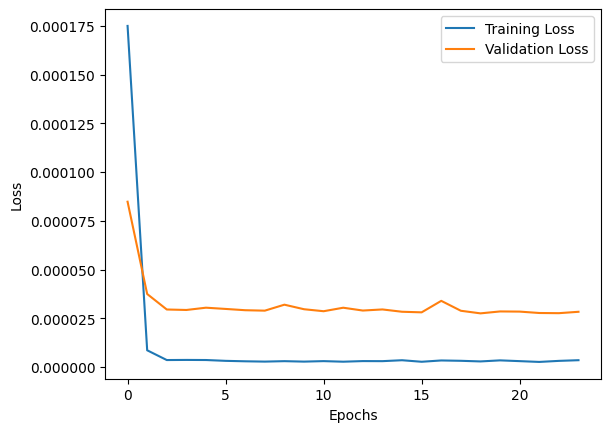

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 3ms/step - loss: 0.0016


0.0016151790041476488

26/26 [==============================] - 0s 3ms/step


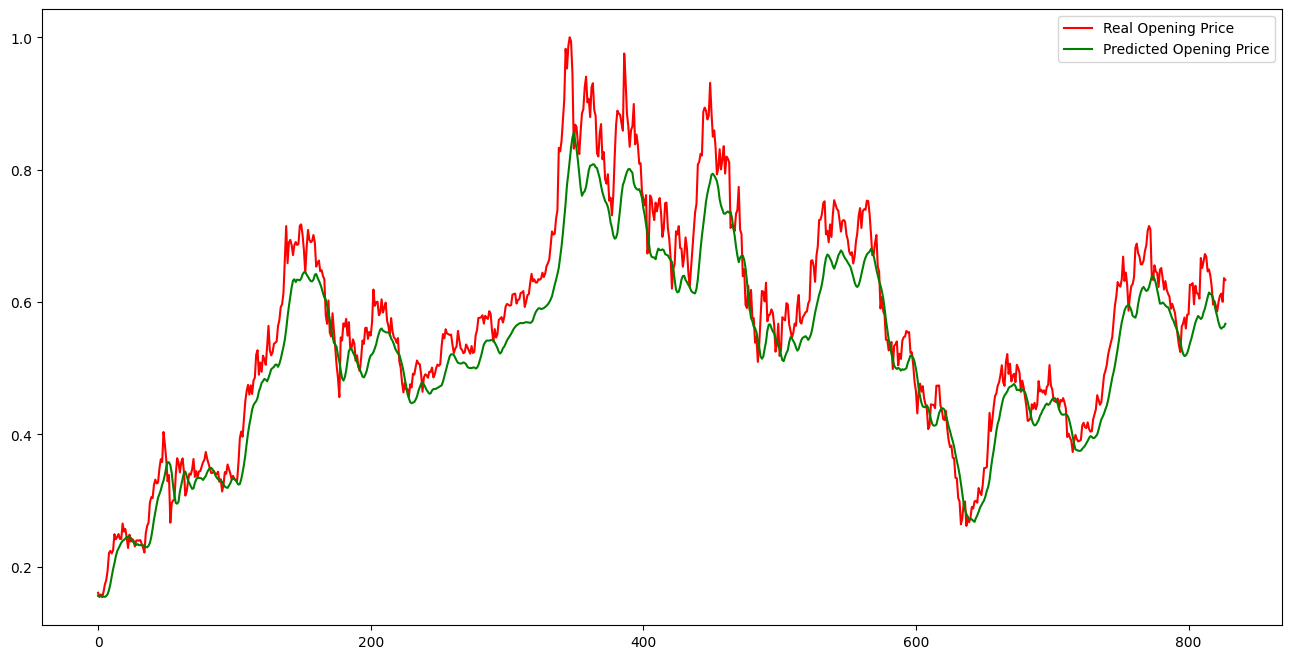

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Closing Price')
plt.plot(y_pred, color='green', label = 'Predicted Closing Price')
plt.legend(loc='best')

In [ ]:
## Using Keras Tuner

In [ ]:
!pip install keras-tuner

In [ ]:
# Hyperparameter  tuner using Keras Tuner
import kerastuner as kt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=200, step=10),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=10)))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()
    return model





In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Adjust the number of trials as needed
    directory='my_tuning_director',  # Change this to a directory of your choice
    project_name='stock_price_tuning'
)

Reloading Tuner from my_tuning_director/stock_price_tuning/tuner0.json


In [ ]:

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'units_1': 180, 'dropout_1': 0.1, 'units_2': 120}


In [ ]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
# Train the model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
79/79 [==============================] - 11s 89ms/step - loss: 1.0579e-04 - mean_absolute_error: 0.0058 - val_loss: 0.0014 - val_mean_absolute_error: 0.0283
Epoch 2/100
79/79 [==============================] - 5s 62ms/step - loss: 1.3880e-05 - mean_absolute_error: 0.0023 - val_loss: 0.0023 - val_mean_absolute_error: 0.0376
Epoch 3/100
79/79 [==============================] - 5s 60ms/step - loss: 1.6194e-05 - mean_absolute_error: 0.0026 - val_loss: 0.0017 - val_mean_absolute_error: 0.0319
Epoch 4/100
79/79 [==============================] - 6s 72ms/step - loss: 1.2560e-05 - mean_absolute_error: 0.0022 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311
Epoch 5/100
79/79 [==============================] - 4s 51ms/step - loss: 1.1386e-05 - mean_absolute_error: 0.0019 - val_loss: 0.0013 - val_mean_absolute_error: 0.0278
Epoch 6/100
79/79 [==============================] - 4s 50ms/step - loss: 1.4028e-05 - mean_absolute_error: 0.0025 - val_loss: 0.0040 - val_mean_absolute_error

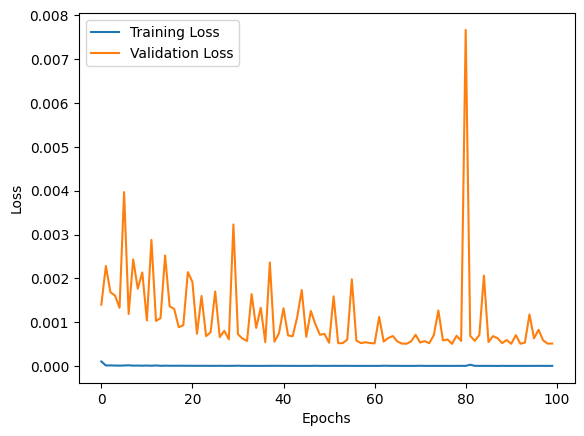

In [ ]:
import matplotlib.pyplot as plt

plt.plot(best_model.history.history['loss'], label='Training Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluating the training model

In [ ]:
predict = best_model.predict(X_train)
predict = MMS.inverse_transform(predict)

tl = MMS.inverse_transform(y_train)

diff = predict - tl

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

79/79 [==============================] - 2s 9ms/step
MSE: 0.6071274954828938
MAE: 0.44287743182113953
RMSE: 0.7791838650042067


In [ ]:
## Evaluating the testing model

In [ ]:
predict = best_model.predict(X_test)
predict = MMS.inverse_transform(predict)
t2 = MMS.inverse_transform(y_test)


26/26 [==============================] - 1s 18ms/step


In [ ]:
diff = predict - t2

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 86.13437923665744
MAE: 6.680472766340319
RMSE: 9.280860910317395


In [ ]:
## Using batch normalization for overfitting

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization

model = Sequential()

# Add the first LSTM layer with Batch Normalization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Add the second LSTM layer with Batch Normalization
model.add(LSTM(units=100))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Output layer
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 6, 100)            40800     
                                                                 
 batch_normalization (Batch  (None, 6, 100)            400       
 Normalization)                                                  
                                                                 
 dropout_19 (Dropout)        (None, 6, 100)            0         
                                                                 
 lstm_23 (LSTM)              (None, 100)               80400     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 100)             

In [ ]:
# fitting the model by iterating the dataset over 100 times(100 epochs)
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test),  verbose = 1)

Epoch 1/100
79/79 [==============================] - 9s 39ms/step - loss: 0.0873 - mean_absolute_error: 0.1878 - val_loss: 0.3124 - val_mean_absolute_error: 0.5338
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - loss: 0.0289 - mean_absolute_error: 0.1091 - val_loss: 0.3066 - val_mean_absolute_error: 0.5279
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - loss: 0.0114 - mean_absolute_error: 0.0665 - val_loss: 0.3023 - val_mean_absolute_error: 0.5241
Epoch 4/100
79/79 [==============================] - 1s 16ms/step - loss: 0.0092 - mean_absolute_error: 0.0602 - val_loss: 0.2189 - val_mean_absolute_error: 0.4470
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.0053 - mean_absolute_error: 0.0454 - val_loss: 0.2514 - val_mean_absolute_error: 0.4801
Epoch 6/100
79/79 [==============================] - 2s 21ms/step - loss: 0.0031 - mean_absolute_error: 0.0366 - val_loss: 0.1346 - val_mean_absolute_error: 0.3490
Epoch 7/100
79/7

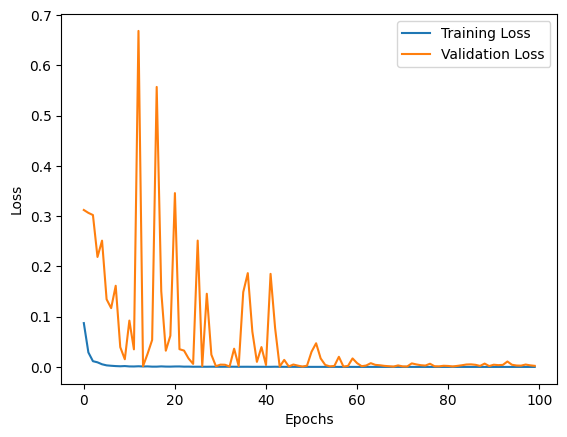

In [ ]:


# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Evaluating the training model

In [ ]:
predict = model.predict(X_train)
predict = MMS.inverse_transform(predict)
t2 = MMS.inverse_transform(y_train)

diff = predict - t2

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

79/79 [==============================] - 2s 7ms/step
MSE: 17.820699976150735
MAE: 4.161150658052897
RMSE: 4.221457091591804


In [ ]:
## Evaluating the testing model

In [ ]:
predict = model.predict(X_test)
predict = MMS.inverse_transform(predict)
t2 = MMS.inverse_transform(y_test)

diff = predict - t2

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

26/26 [==============================] - 0s 5ms/step
MSE: 365.98510318602433
MAE: 15.703850222447198
RMSE: 19.130737131277098


In [ ]:
# predicting the values after running the model
test_predicted = model.predict(X_test)
test_predicted[:5]

26/26 [==============================] - 0s 6ms/step


array([[0.15158844],
       [0.15211788],
       [0.1478194 ],
       [0.1488744 ],
       [0.14657333]], dtype=float32)

In [ ]:
# Inversing normalization/scaling on predicted data
test_inverse_predicted = MMS.inverse_transform(test_predicted)
test_inverse_predicted[:5]

array([[63.04037 ],
       [63.256866],
       [61.499146],
       [61.930553],
       [60.98961 ]], dtype=float32)

### VISUALIZING ACTUAL VS PREDICTED DATA

In [ ]:
# Merging actual and predicted data for better visualization
df_merge = pd.concat([df.iloc[-828:].copy(),
                          pd.DataFrame(test_inverse_predicted,columns=['close_predicted'],
                                       index=df.iloc[-828:].index)], axis=1)

In [ ]:
# Inversing normalization/scaling
df_merge[['Close']] = MMS.inverse_transform(df_merge[['Close']])
df_merge.head()

,Close,close_predicted
Date,,
2020-06-23,66.785332,63.040371
2020-06-24,64.056664,63.256866
2020-06-25,65.732002,61.499146
2020-06-26,63.982666,61.930553
2020-06-29,67.290001,60.989609


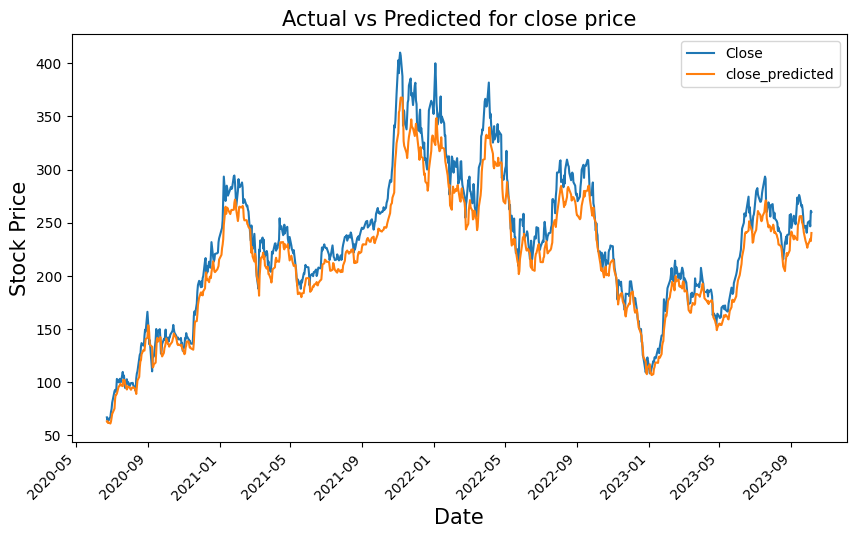

In [ ]:
# plotting the actual close and predicted close prices on date index
df_merge[['Close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

### PREDICTING UPCOMING 10 DAYS

In [ ]:
# Creating a dataframe and adding 10 days to existing index

df_merge = df_merge.append(pd.DataFrame(columns=df_merge.columns,
                                        index=pd.date_range(start='2023-10-06', end='2023-10-15')))
df_merge

,Close,close_predicted
2020-06-23,66.785332,63.040371
2020-06-24,64.056664,63.256866
2020-06-25,65.732002,61.499146
2020-06-26,63.982666,61.930553
2020-06-29,67.290001,60.989609
...,...,...
2023-10-11,NaN,NaN
2023-10-12,NaN,NaN
2023-10-13,NaN,NaN
2023-10-14,NaN,NaN


In [ ]:
# creating a DataFrame and filling values of open and close column
upcoming_prediction = pd.DataFrame(columns=['Close'],index=df_merge.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [ ]:
curr_seq = X_test[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(X_test[-1:].shape)

1/1 [==============================] - 0s 30ms/step


In [ ]:
# inversing Normalization/scaling
upcoming_prediction[['Close']] = MMS.inverse_transform(upcoming_prediction[['Close']])

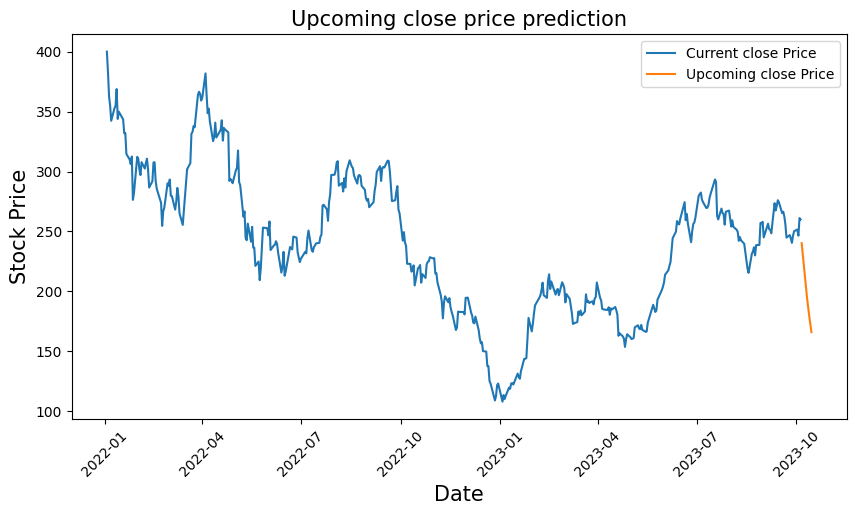

In [ ]:
# plotting Upcoming Close price on date index
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(df_merge.loc['2022-01-01':,'Close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2022-01-01':,'Close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fig.show()

# THANK YOU!